# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [2046]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score,
    classification_report,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from utility import download_and_unzip
from prettytable import PrettyTable
from graphviz import Digraph
from IPython.display import Image, display, Markdown
import pycountry, math
from sklearn.metrics import silhouette_score

# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings

# Suppress only FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)


## Data Wrangling

In [2047]:
# @title Download the data
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
# !unzip -qq Online_Retail.zip

download_and_unzip(
    url="https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip",
    filename="Online_Retail.zip",
)


False

## Load the data

In [2048]:
# YOUR CODE HERE
df = pd.read_csv("Online_Retail_Train.csv")


In [2049]:
# capture all observations in a list
observations = []


## Common Functions
1. Remove duplicate data rows: find_and_remove_null_values

In [2050]:
def find_and_remove_null_values(df_):
    df_.isna().sum()
    df = df_.dropna()
    return df


In [2051]:
def show_basic_details(df_):
    print("Dataset's datatype, number of rows and columns:\n", df_.info(), "\n\n")
    print("Statistics of the Numerical variables:\n", df_.describe(), "\n\n")
    print("Rows with null or empty fields:\n", df_.isna().sum(), "\n\n")


In [2052]:
def add_new_column_invoice_type(df_, drop_invoice_no=True):
    df_["TransactionType"] = df_["InvoiceNo"].apply(
        lambda x: "Cancelled"
        if x.startswith("C")
        else ("Adjusted" if x.startswith("A") else "Sale")
    )
    print("Column InvoiceType Added")
    if drop_invoice_no:
        df_ = df_.drop("InvoiceNo", axis=1)
        print("Column InvoiceNo Dropped")

    return df_


In [2053]:
def add_total_price_column(df_):
    df_["TotalItemPrice"] = df_["Quantity"] * df_["UnitPrice"]
    return df_


In [2054]:
def truncate(value, length=10):
    if isinstance(value, str):
        return value[:length] + "..." if len(value) > length else value
    return value


In [2055]:
def display_dataframe_as_table(df_categorical_info):
    table = PrettyTable()
    table.field_names = df_categorical_info.columns.tolist()

    for _, row in df_categorical_info.iterrows():
        table.add_row([truncate(row[col], 40) for col in df_categorical_info.columns])

    # Print the PrettyTable
    print(table)


In [2056]:
# Extract summary statistics of categorical columns
def extract_summary_statistics_categorical(
    df_, categorical_columns_, display_table=True
):
    df_categorical_info = pd.DataFrame(
        columns=[
            "Column",
            "Unique Values",
            "Count of Unique Values",
            "Missing Values",
            "Data Type",
            "Categorical Type",
        ]
    )

    for col in categorical_columns_:
        unique_values = df_[col].unique()
        count_unique_values = df_[col].nunique()
        missing_values = df_[col].isnull().sum()
        unique_val = ", ".join(unique_values.astype(str))
        col_dtype = df_[col].dtype
        cat_type = "Nominal"

        # Append the information to the dataframe
        temp_df = pd.DataFrame(
            {
                "Column": col,
                "Unique Values": [unique_val],
                "Count of Unique Values": count_unique_values,
                "Missing Values": missing_values,
                "Data Type": [col_dtype],
                "Categorical Type": cat_type,
            }
        )

        df_categorical_info = pd.concat([df_categorical_info, temp_df], axis=0)
    if display_table:
        display_dataframe_as_table(df_categorical_info)
    return df_categorical_info


In [2057]:
def extract_summary_statistics_numerical(df_, numerical_columns_, display_table=True):
    df_numerical_info = pd.DataFrame(
        columns=[
            "Column",
            "Mean",
            "Median (50th Percentile)",
            "Mode",
            "Min",
            "Max",
            "Range",
            "Standard Deviation",
            "Variance",
            "25th Percentile",
            "50th Percentile (Median)",
            "75th Percentile",
            "Count of Unique Values",
            "Missing Values",
            "Data Type",
        ]
    )

    # Iterate through each numerical column and collect the required information
    for col in numerical_columns_:
        mean = df_[col].mean()
        median = df_[col].median()
        mode = df_[col].mode()[0]
        minimum = df_[col].min()
        maximum = df_[col].max()
        range_val = maximum - minimum
        std_dev = df_[col].std()
        variance = df_[col].var()
        missing_values = df_[col].isnull().sum()
        percentile_25 = df_[col].quantile(0.25)
        percentile_50 = df_[col].quantile(0.50)
        percentile_75 = df_[col].quantile(0.75)
        count_unique_values = df_[col].nunique()
        col_dtype = df_[col].dtype
        # Append the information to the dataframe
        temp_df = pd.DataFrame(
            {
                "Column": col,
                "Mean": [mean],
                "Median (50th Percentile)": [median],
                "Mode": [mode],
                "Min": [minimum],
                "Max": [maximum],
                "Range": [range_val],
                "Standard Deviation": [std_dev],
                "Variance": [variance],
                "25th Percentile": [percentile_25],
                "50th Percentile (Median)": [percentile_50],
                "75th Percentile": [percentile_75],
                "Count of Unique Values": count_unique_values,
                "Missing Values": [missing_values],
                "Data Type": [col_dtype],
            }
        )

        df_numerical_info = pd.concat([df_numerical_info, temp_df], axis=0)
    if display_table:
        display_dataframe_as_table(df_numerical_info)
    return df_numerical_info


In [2058]:
def split_date_timestamp_into_components(df_, datetime_col_name):
    df_[datetime_col_name] = pd.to_datetime(df_[datetime_col_name])
    df_["Year"] = df_[datetime_col_name].dt.year
    df_["Month"] = df_[datetime_col_name].dt.month
    df_["Day"] = df_[datetime_col_name].dt.day
    # df_["Hour"] = df_[datetime_col_name].dt.hour
    # df_["Minute"] = df_[datetime_col_name].dt.minute
    # df_["Second"] = df_[datetime_col_name].dt.second
    # df_["Weekday"] = df_[datetime_col_name].dt.weekday
    # df_["Quarter"] = df_[datetime_col_name].dt.quarter
    # df_["Week"] = df_[datetime_col_name].dt.week
    # df_["WeekOfYear"] = df_[datetime_col_name].dt.isocalendar().week
    # df_["DayOfYear"] = df_[datetime_col_name].dt.dayofyear
    # df_["Date"] = df_[datetime_col_name].dt.date
    # df_["Time"] = df_[datetime_col_name].dt.time
    # df_["Timestamp"] = df_[datetime_col_name].dt.timestamp
    df["DayOfWeek"] = df["InvoiceDate"].dt.day_name()
    df_ = df_.drop(datetime_col_name, axis=1)
    return df_


In [2059]:
# extract data from customer id


def extract_customer_id(df_, customer_id_col_name, drop_customer_id=True):
    customer_counts = df_[customer_id_col_name].value_counts(dropna=False)

    def assign_customer_type(customer_id):
        if pd.isna(customer_id):
            return "unknown"
        elif customer_counts[customer_id] == 1:
            return "unique"
        else:
            return "repeat"

    df_["CustomerType"] = df_["CustomerID"].apply(assign_customer_type)

    if drop_customer_id:
        df_ = df_.drop("CustomerID", axis=1)

    return df_


In [2060]:
def scale_numerical_columns(df_, numerical_columns_):
    scaler = StandardScaler()
    df_[numerical_columns_] = scaler.fit_transform(df_[numerical_columns_])
    return df_


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://thecleverprogrammer.com/2023/07/26/detect-and-remove-outliers-using-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

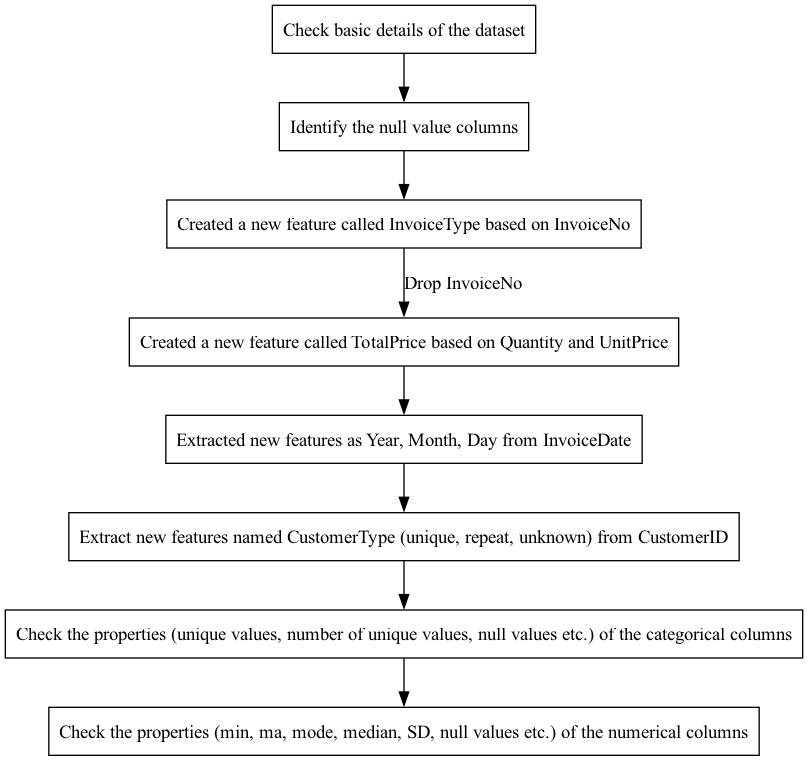

In [2061]:
# Write the flow that I have taken to clean the data

flowchart = Digraph(format="png", name="basic_flowchart")
# Add nodes. Note Node Shapes can be: box. polygon. ellipse. oval. circle. point. egg. triangle.
# flowchart.attr(rankdir="LR")
# flowchart.attr(rankdir="TB")

# flowchart.node("0", "Basic Checks", shape="box")
flowchart.node("1", "Check basic details of the dataset", shape="box")
flowchart.node("2", "Identify the null value columns", shape="box")
flowchart.node(
    "3", "Created a new feature called InvoiceType based on InvoiceNo", shape="box"
)
flowchart.node(
    "4",
    "Created a new feature called TotalPrice based on Quantity and UnitPrice",
    shape="box",
)
flowchart.node(
    "5", "Extracted new features as Year, Month, Day from InvoiceDate", shape="box"
)

flowchart.node(
    "6",
    "Extract new features named CustomerType (unique, repeat, unknown) from CustomerID",
    shape="box",
)

flowchart.node(
    "7",
    "Check the properties (unique values, number of unique values, null values etc.) of the categorical columns",
    shape="box",
)

flowchart.node(
    "8",
    "Check the properties (min, ma, mode, median, SD, null values etc.) of the numerical columns",
    shape="box",
)

# Add edges
flowchart.edges(
    [("1", "2"), ("2", "3"), ("4", "5"), ("5", "6"), ("6", "7"), ("7", "8")]
)


flowchart.edge("3", "4", label="Drop InvoiceNo")

# Render and save
flowchart.render("basic_flowchart", format="png", cleanup=True)
display(Image("basic_flowchart.png"))


In [2062]:
df.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2011-08-30 10:39:00,2.46,NaN,United Kingdom
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,2011-10-16 12:21:00,1.95,13034.0,United Kingdom


In [2063]:
# YOUR CODE HERE
show_basic_details(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514813 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    514813 non-null  object 
 1   StockCode    514813 non-null  object 
 2   Description  513428 non-null  object 
 3   Quantity     514813 non-null  int64  
 4   InvoiceDate  514813 non-null  object 
 5   UnitPrice    514813 non-null  float64
 6   CustomerID   386550 non-null  float64
 7   Country      514813 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 31.4+ MB
Dataset's datatype, number of rows and columns:
 None 


Statistics of the Numerical variables:
             Quantity      UnitPrice     CustomerID
count  514813.000000  514813.000000  386550.000000
mean        9.552498       4.586406   15288.936753
std       223.529242      95.660226    1713.565852
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13955.0

### There is a lot of redundant data. Identify such data and take appropriate action.

In [2064]:
unique_values_count = {col: df[col].nunique() for col in df.columns}
unique_df = pd.DataFrame(
    list(unique_values_count.items()),
    columns=["ColumnName", "UniqueValuesCount"],
)
unique_df["TotalRows"] = len(df)
unique_df.head(n=10)


,ColumnName,UniqueValuesCount,TotalRows
0,InvoiceNo,25610,514813
1,StockCode,4062,514813
2,Description,4210,514813
3,Quantity,713,514813
4,InvoiceDate,23059,514813
5,UnitPrice,1582,514813
6,CustomerID,4367,514813
7,Country,38,514813


#### Analyze InvoiceNo

In [2065]:
invoice_no_unique_values = df["InvoiceNo"].unique()
invoice_no_unique_values


array(['579427', '554092', '577774', ..., '542965', 'C546870', '575696'],
      shape=(25610,), dtype=object)

In [2066]:
invoice_no_unique_values[0]


'579427'

In [2067]:
one_invoice_df = df[df["InvoiceNo"] == invoice_no_unique_values[0]]
one_invoice_df


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
41327,579427,23020,GLASS SONGBIRD STORAGE JAR,1,2011-11-29 13:04:00,12.50,16479.0,United Kingdom
68592,579427,23418,LAVENDER TOILETTE BOTTLE,6,2011-11-29 13:04:00,2.08,16479.0,United Kingdom
82427,579427,22667,RECIPE BOX RETROSPOT,2,2011-11-29 13:04:00,2.95,16479.0,United Kingdom
84351,579427,23169,CLASSIC GLASS COOKIE JAR,6,2011-11-29 13:04:00,4.15,16479.0,United Kingdom
92045,579427,23084,RABBIT NIGHT LIGHT,4,2011-11-29 13:04:00,2.08,16479.0,United Kingdom
133249,579427,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,3,2011-11-29 13:04:00,2.95,16479.0,United Kingdom
172568,579427,21034,REX CASH+CARRY JUMBO SHOPPER,1,2011-11-29 13:04:00,0.95,16479.0,United Kingdom
175931,579427,21189,WHITE HONEYCOMB PAPER GARLAND,4,2011-11-29 13:04:00,1.65,16479.0,United Kingdom
175934,579427,85034C,3 ROSE MORRIS BOXED CANDLES,3,2011-11-29 13:04:00,1.25,16479.0,United Kingdom


In [2068]:
observations.append(
    [
        f"Column InvoiceNo has {df['InvoiceNo'].nunique()} unique values out of {len(df)} total rows. InvoiceNo repeats in the dataset. Take the example of InvoiceNo {invoice_no_unique_values[0]}, it has {len(one_invoice_df)} rows in the dataset. Repeated InvoiceNo should not be deleted as they capture different items bought by the same customer.",
        "InvoiceNo has two different types of values: Cancellation and Sale. Created a new feature called InvoiceType based on InvoiceNo. Dropped InvoiceNo column.",
    ]
)


#### Analyze StockCode & Description

In [2069]:
result = df.groupby("StockCode").agg(desc_cnt=("Description", "count")).reset_index()
result[result["desc_cnt"] > 1]


,StockCode,desc_cnt
0,10002,68
1,10080,21
2,10120,30
3,10123C,3
5,10124A,5
...,...,...
4056,gift_0001_10,8
4057,gift_0001_20,10
4058,gift_0001_30,6
4059,gift_0001_40,3


In [2070]:
result1 = (
    df.groupby("Description").agg(stock_code_cnt=("StockCode", "count")).reset_index()
)
result1[result1["stock_code_cnt"] > 1]


,Description,stock_code_cnt
0,4 PURPLE FLOCK DINNER CANDLES,40
1,50'S CHRISTMAS GIFT BAG LARGE,124
2,DOLLY GIRL BEAKER,169
3,I LOVE LONDON MINI BACKPACK,86
5,NINE DRAWER OFFICE TIDY,33
...,...,...
4191,wet damaged,5
4192,wet pallet,3
4193,wet rusty,2
4194,wet/rusty,2


In [2071]:
observations.append(
    ["StockCode and Description columns don't have matching number of unique values."]
)


#### Analyze Quantity & UnitPrice

In [2072]:
print(f"Number of records with Quantity set to 0 are: {len(df[df['Quantity'] == 0])}")
df_unit_price_zero = df[df["UnitPrice"] == 0]
no_records_with_unit_price_zero = len(df_unit_price_zero)
print(
    f"Number of records with UnitPrice set to 0 are: {no_records_with_unit_price_zero}"
)


Number of records with Quantity set to 0 are: 0
Number of records with UnitPrice set to 0 are: 2401


In [2073]:
df_unit_price_zero.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
347,556286,16052,NaN,-16,2011-06-10 09:22:00,0.0,NaN,United Kingdom
693,542560,47579,NaN,-1,2011-01-28 14:51:00,0.0,NaN,United Kingdom
1306,549035,72051S,NaN,-15,2011-04-05 17:09:00,0.0,NaN,United Kingdom
1484,576424,85036C,check,-4,2011-11-15 11:24:00,0.0,NaN,United Kingdom
1535,562945,79000,NaN,425,2011-08-11 09:35:00,0.0,NaN,United Kingdom
1691,554143,79030G,damages,-413,2011-05-23 10:40:00,0.0,NaN,United Kingdom
1862,561484,77081,NaN,-39,2011-07-27 13:41:00,0.0,NaN,United Kingdom
1974,553521,22363,GLASS JAR MARMALADE,1,2011-05-17 14:35:00,0.0,NaN,United Kingdom
2031,578632,22579,NaN,4,2011-11-24 16:22:00,0.0,NaN,United Kingdom
2044,551722,20975,NaN,-170,2011-05-03 16:50:00,0.0,NaN,United Kingdom


In [2074]:
no_nan_customer = int(df_unit_price_zero["CustomerID"].isna().sum())


In [2075]:
free_items = df_unit_price_zero[
    (~df_unit_price_zero["CustomerID"].isna()) & (df_unit_price_zero["Quantity"] > 0)
]
free_items.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
24182,574175,22065,CHRISTMAS PUDDING TRINKET POT,12,2011-11-03 11:47:00,0.0,14110.0,United Kingdom
30553,575579,22437,SET OF 9 BLACK SKULL BALLOONS,20,2011-11-10 11:49:00,0.0,13081.0,United Kingdom
48157,571035,M,Manual,1,2011-10-13 12:50:00,0.0,12446.0,RSA
54128,577168,M,Manual,1,2011-11-18 10:42:00,0.0,12603.0,Germany
115656,572893,21208,PASTEL COLOUR HONEYCOMB FAN,5,2011-10-26 14:36:00,0.0,18059.0,United Kingdom
120009,568384,M,Manual,1,2011-09-27 09:46:00,0.0,12748.0,United Kingdom
142943,553000,47566,PARTY BUNTING,4,2011-05-12 15:21:00,0.0,17667.0,United Kingdom
173878,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom
176474,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
194189,561916,M,Manual,1,2011-08-01 11:44:00,0.0,15581.0,United Kingdom


In [2076]:
no_of_free_items = len(free_items)
free_items_customer = len(free_items["CustomerID"])


In [2077]:
free_stuff_under_suspicion = df[
    (df["UnitPrice"] == 0) & (df["Quantity"] > 0) & (df["CustomerID"].isna())
]
no_of_free_items_under_suspicion = len(free_stuff_under_suspicion)
free_stuff_under_suspicion.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1535,562945,79000,NaN,425,2011-08-11 09:35:00,0.0,NaN,United Kingdom
1974,553521,22363,GLASS JAR MARMALADE,1,2011-05-17 14:35:00,0.0,NaN,United Kingdom
2031,578632,22579,NaN,4,2011-11-24 16:22:00,0.0,NaN,United Kingdom
2163,558340,48184,DOORMAT ENGLISH ROSE,3,2011-06-28 14:01:00,0.0,NaN,United Kingdom
4078,578700,72807A,AMAZON,1,2011-11-25 10:49:00,0.0,NaN,United Kingdom
4495,565070,85032D,NaN,171,2011-08-31 17:18:00,0.0,NaN,United Kingdom
4750,565797,47570B,NaN,1,2011-09-07 10:15:00,0.0,NaN,United Kingdom
5955,539856,84692,BOX OF 24 COCKTAIL PARASOLS,2,2010-12-22 14:41:00,0.0,NaN,United Kingdom
6714,558340,22666,RECIPE BOX PANTRY YELLOW DESIGN,1,2011-06-28 14:01:00,0.0,NaN,United Kingdom
7234,542513,75013B,NaN,2,2011-01-28 12:08:00,0.0,NaN,United Kingdom


In [2078]:
observations.append(
    [
        "There are no records where Quantity is set to 0.",
        f"There are {no_records_with_unit_price_zero} records where UnitPrice is set to 0.",
        f"Among these zero unit price records, {no_nan_customer} records have CustomerID set to NaN or customer is unknown.",
        f"There are {no_of_free_items} records where UnitPrice is set to 0 and Quantity is greater than 0. These {no_of_free_items} items are given for free.",
        f"These free items are given to {free_items_customer} customers.",
        f"Number of free items given to unknown customers are: {no_of_free_items_under_suspicion}",
    ]
)


#### Analyze Country


In [2079]:
def is_legitimate_country(country_name):
    try:
        # Search for the country in pycountry
        country = pycountry.countries.lookup(country_name)
        return True
    except LookupError:
        return False


df["Is_Legitimate_Country_Name"] = df["Country"].apply(is_legitimate_country)
df_incorrect_country = df[df["Is_Legitimate_Country_Name"] == False]
incorrect_country_names = df_incorrect_country["Country"].unique()
incorrect_country_count = len(df_incorrect_country)
print(f"Number of incorrect country names: {incorrect_country_count} out of {len(df)}")
print(f"Incorrect country names: {incorrect_country_names}")


Number of incorrect country names: 9022 out of 514813
Incorrect country names: ['EIRE' 'Unspecified' 'Channel Islands' 'European Community' 'RSA']


In [2080]:
observations.append(
    [
        f"Number of incorrect country names: {incorrect_country_count} out of {len(df)}",
        f"Incorrect country names: {incorrect_country_names}",
    ]
)


In [2081]:
df.drop("Is_Legitimate_Country_Name", axis=1, inplace=True)


### Data Processing for null value column


In [2082]:
# Find and remove the rows with missing values
# YOUR CODE HERE
df.isna().sum()

# df_1 = find_and_remove_null_values(df)


InvoiceNo           0
StockCode           0
Description      1385
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     128263
Country             0
dtype: int64

##### Treat Dataset based on CustomerID

In [2083]:
df = extract_customer_id(df, "CustomerID", drop_customer_id=False)
df.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,repeat
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,repeat
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,repeat
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,unknown
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,unknown
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,repeat
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2011-08-30 10:39:00,2.46,NaN,United Kingdom,unknown
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,repeat
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom,repeat
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,2011-10-16 12:21:00,1.95,13034.0,United Kingdom,repeat


##### Treat empty description

### Convert InvoiceNo to TransactionType
Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

In [2084]:
# Add a new column InvoiceType to the dataframe
df = add_new_column_invoice_type(df, drop_invoice_no=False)
df.head(n=10)


Column InvoiceType Added


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,repeat,Sale
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,repeat,Sale
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,repeat,Sale
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,unknown,Cancelled
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,unknown,Sale
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,repeat,Sale
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2011-08-30 10:39:00,2.46,NaN,United Kingdom,unknown,Sale
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,repeat,Sale
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom,repeat,Sale
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,2011-10-16 12:21:00,1.95,13034.0,United Kingdom,repeat,Sale


In [2085]:
df["TransactionType"].unique()


array(['Sale', 'Cancelled', 'Adjusted'], dtype=object)

In [2086]:
df[df["TransactionType"] == "Cancelled"].head(n=5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,unknown,Cancelled
34,C578367,22759,SET OF 3 NOTEBOOKS IN PARCEL,-12,2011-11-24 11:00:00,1.65,14640.0,United Kingdom,repeat,Cancelled
121,C573010,20979,36 PENCILS TUBE RED RETROSPOT,-11,2011-10-27 12:29:00,1.25,13735.0,United Kingdom,repeat,Cancelled
219,C570828,90059E,DIAMANTE HAIR GRIP PACK/2 RUBY,-6,2011-10-12 13:15:00,1.65,14911.0,EIRE,repeat,Cancelled
220,C563693,84050,PINK HEART SHAPE EGG FRYING PAN,-1,2011-08-18 13:04:00,1.65,17243.0,United Kingdom,repeat,Cancelled


In [2087]:
df[df["TransactionType"] == "Adjusted"].head(n=5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType
51050,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,unknown,Adjusted
279008,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,unknown,Adjusted
405078,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,unknown,Adjusted


In [2088]:
df[df["TransactionType"] == "Sale"].head(n=5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,repeat,Sale
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,repeat,Sale
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,repeat,Sale
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,unknown,Sale
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,repeat,Sale


###  Remove irrelevant transactions based on StockCodes 
Some of the transactions based on the StockCode variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

Hint:

The transaction with 'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES' as their StockCodes are considered as irrelevant transactions.

In [2089]:
def remove_irrelevant_transactions_based_on_stock_code(
    df_, irrelevant_stock_codes, col
):
    df_ = df_[~df_[col].isin(irrelevant_stock_codes)]
    return df_


df = remove_irrelevant_transactions_based_on_stock_code(
    df,
    irrelevant_stock_codes=["POST", "PADS", "M", "DOT", "C2", "BANK CHARGES"],
    col="StockCode",
)
print(df.shape)
df.head(n=10)


(512228, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,repeat,Sale
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,repeat,Sale
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,repeat,Sale
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,unknown,Cancelled
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,unknown,Sale
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,repeat,Sale
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2011-08-30 10:39:00,2.46,NaN,United Kingdom,unknown,Sale
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,repeat,Sale
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom,repeat,Sale
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,2011-10-16 12:21:00,1.95,13034.0,United Kingdom,repeat,Sale


### Add TotalItemPrice based on UnitPrice and Quantity

In [2090]:
# Add a new column TotalPrice to the dataframe
df = add_total_price_column(df)
df.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,repeat,Sale,17.00
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,repeat,Sale,10.08
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,repeat,Sale,2.52
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,2011-10-14 12:02:00,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,2011-03-15 14:17:00,7.46,NaN,United Kingdom,unknown,Sale,7.46
5,579668,23575,SNACK TRAY PAISLEY PARK,8,2011-11-30 12:32:00,1.95,15152.0,United Kingdom,repeat,Sale,15.60
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2011-08-30 10:39:00,2.46,NaN,United Kingdom,unknown,Sale,2.46
7,547684,23176,ABC TREASURE BOOK BOX,8,2011-03-24 14:46:00,2.25,12408.0,Belgium,repeat,Sale,18.00
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,2011-11-11 13:29:00,0.42,13588.0,United Kingdom,repeat,Sale,5.04
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,2011-10-16 12:21:00,1.95,13034.0,United Kingdom,repeat,Sale,15.60


### Break InvoiceDate into Year, Month and Day

In [2091]:
df = split_date_timestamp_into_components(df, "InvoiceDate")
df.head(n=10)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,8.50,16479.0,United Kingdom,repeat,Sale,17.00,2011,11,29,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,0.42,17176.0,United Kingdom,repeat,Sale,10.08,2011,5,22,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,0.42,16712.0,United Kingdom,repeat,Sale,2.52,2011,11,21,Monday
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1,7.46,NaN,United Kingdom,unknown,Sale,7.46,2011,3,15,Tuesday
5,579668,23575,SNACK TRAY PAISLEY PARK,8,1.95,15152.0,United Kingdom,repeat,Sale,15.60,2011,11,30,Wednesday
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1,2.46,NaN,United Kingdom,unknown,Sale,2.46,2011,8,30,Tuesday
7,547684,23176,ABC TREASURE BOOK BOX,8,2.25,12408.0,Belgium,repeat,Sale,18.00,2011,3,24,Thursday
8,575878,21519,GIN & TONIC DIET GREETING CARD,12,0.42,13588.0,United Kingdom,repeat,Sale,5.04,2011,11,11,Friday
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8,1.95,13034.0,United Kingdom,repeat,Sale,15.60,2011,10,16,Sunday


### Identify Outliers in the UnitPrice and Quantity
Identify the outliers in the UnitPrice and Quantity and handle them accordingly.

In [2092]:
# divide the columns into categorical, numerical and useless columns
categorical_columns = [
    "StockCode",
    "Country",
    "TransactionType",
    "Year",
    "Month",
    "Day",
    "CustomerType",
]

numerical_columns = [
    "Quantity",
    "UnitPrice",
    "TotalItemPrice",
]

useless_columns = [
    "Description",
]


In [2093]:
df_cat_summary = extract_summary_statistics_categorical(
    df, categorical_columns, display_table=True
)
df_cat_summary


+-----------------+---------------------------------------------+------------------------+----------------+-----------+------------------+
|      Column     |                Unique Values                | Count of Unique Values | Missing Values | Data Type | Categorical Type |
+-----------------+---------------------------------------------+------------------------+----------------+-----------+------------------+
|    StockCode    | 22636, 21916, 84692, 23350, 84509a, 2357... |          4056          |       0        |   object  |     Nominal      |
|     Country     | United Kingdom, Belgium, EIRE, Portugal,... |           38           |       0        |   object  |     Nominal      |
| TransactionType |          Sale, Cancelled, Adjusted          |           3            |       0        |   object  |     Nominal      |
|       Year      |                  2011, 2010                 |           2            |       0        |   int32   |     Nominal      |
|      Month      |    11, 

,Column,Unique Values,Count of Unique Values,Missing Values,Data Type,Categorical Type
0,StockCode,"22636, 21916, 84692, 23350, 84509a, 23575, 849...",4056,0,object,Nominal
0,Country,"United Kingdom, Belgium, EIRE, Portugal, Norwa...",38,0,object,Nominal
0,TransactionType,"Sale, Cancelled, Adjusted",3,0,object,Nominal
0,Year,"2011, 2010",2,0,int32,Nominal
0,Month,"11, 5, 10, 3, 8, 4, 12, 9, 6, 1, 7, 2",12,0,int32,Nominal
0,Day,"29, 22, 21, 14, 15, 30, 24, 11, 16, 27, 18, 8,...",31,0,int32,Nominal
0,CustomerType,"repeat, unknown, unique",3,0,object,Nominal


In [2094]:
df_num_summary = extract_summary_statistics_numerical(
    df, numerical_columns, display_table=False
)
df_num_summary


,Column,Mean,Median (50th Percentile),Mode,Min,Max,Range,Standard Deviation,Variance,25th Percentile,50th Percentile (Median),75th Percentile,Count of Unique Values,Missing Values,Data Type
0,Quantity,9.576075,3.00,1,-80995,80995,161990,224.047568,50197.312802,1.00,3.00,10.00,711,0,int64
0,UnitPrice,3.702754,2.08,1.25,-11062.06,17836.46,28898.52,70.781529,5010.024777,1.25,2.08,4.13,671,0,float64
0,TotalItemPrice,17.735628,9.36,15.0,-168469.6,168469.6,336939.2,382.963623,146661.136745,3.40,9.36,17.40,5150,0,float64


In [2095]:
observations.append("`Quantity` has `negative` values.")


In [2096]:
def create_boxplots(df_, numerical_columns_):
    sns.set_theme(style="whitegrid", palette="pastel")
    plots_per_row = 3

    num_columns = len(numerical_columns_)
    num_rows = math.ceil(num_columns / plots_per_row)

    # Create subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each numerical column in its own subplot
    for i, column in enumerate(numerical_columns_):
        df_[column].plot(kind="box", ax=axes[i])
        axes[i].set_title(f"{column}")
        axes[i].grid(True)

    # Remove any empty subplots
    for j in range(len(numerical_columns_), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


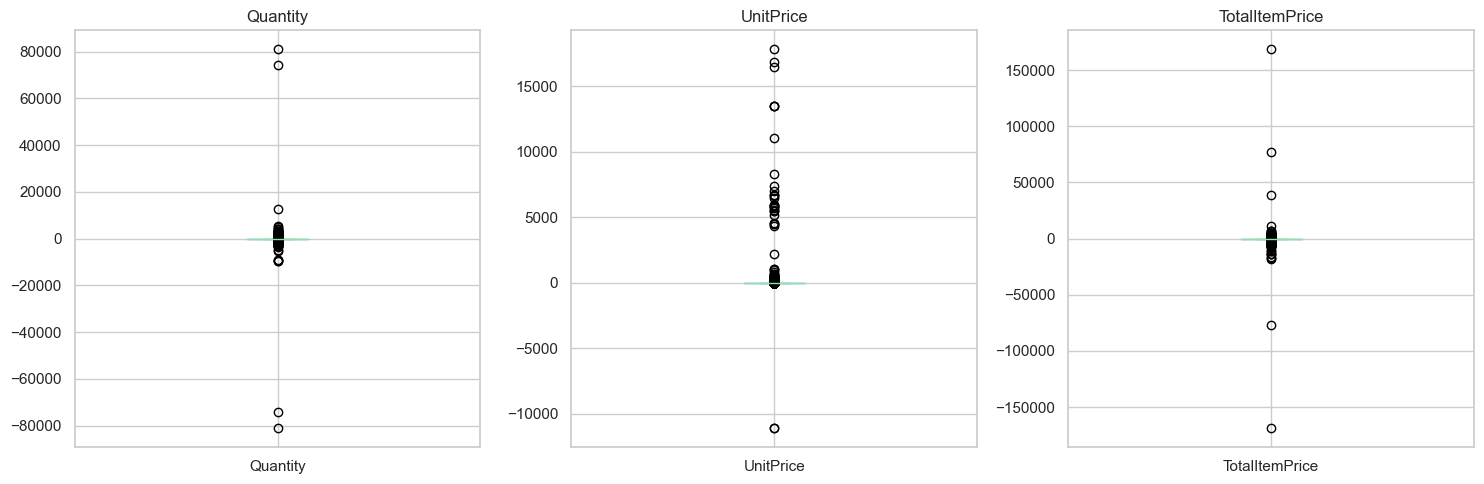

In [2097]:
# Generate box plot for all numerical variable columns
create_boxplots(df, numerical_columns_=numerical_columns)


In [2098]:
def treat_outliers(df_, numerical_columns_):
    print(numerical_columns_)
    for col in numerical_columns_:
        Q1 = df_[col].quantile(0.25)
        Q3 = df_[col].quantile(0.75)
        lower_fence = Q1 - 1.5 * (Q3 - Q1)
        upper_fence = Q3 + 1.5 * (Q3 - Q1)

        df_[col] = df_[col].apply(
            lambda x: Q1 if x < lower_fence else (Q3 if x > upper_fence else x)
        )
    return df_


In [2099]:
df = treat_outliers(df, numerical_columns_=numerical_columns)
df.head(n=10)


['Quantity', 'UnitPrice', 'TotalItemPrice']


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,4.13,16479.0,United Kingdom,repeat,Sale,17.00,2011,11,29,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,10.0,0.42,17176.0,United Kingdom,repeat,Sale,10.08,2011,5,22,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6.0,0.42,16712.0,United Kingdom,repeat,Sale,2.52,2011,11,21,Monday
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12.0,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1.0,7.46,NaN,United Kingdom,unknown,Sale,7.46,2011,3,15,Tuesday
5,579668,23575,SNACK TRAY PAISLEY PARK,8.0,1.95,15152.0,United Kingdom,repeat,Sale,15.60,2011,11,30,Wednesday
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1.0,2.46,NaN,United Kingdom,unknown,Sale,2.46,2011,8,30,Tuesday
7,547684,23176,ABC TREASURE BOOK BOX,8.0,2.25,12408.0,Belgium,repeat,Sale,18.00,2011,3,24,Thursday
8,575878,21519,GIN & TONIC DIET GREETING CARD,12.0,0.42,13588.0,United Kingdom,repeat,Sale,5.04,2011,11,11,Friday
9,571273,22898,CHILDRENS APRON APPLES DESIGN,8.0,1.95,13034.0,United Kingdom,repeat,Sale,15.60,2011,10,16,Sunday


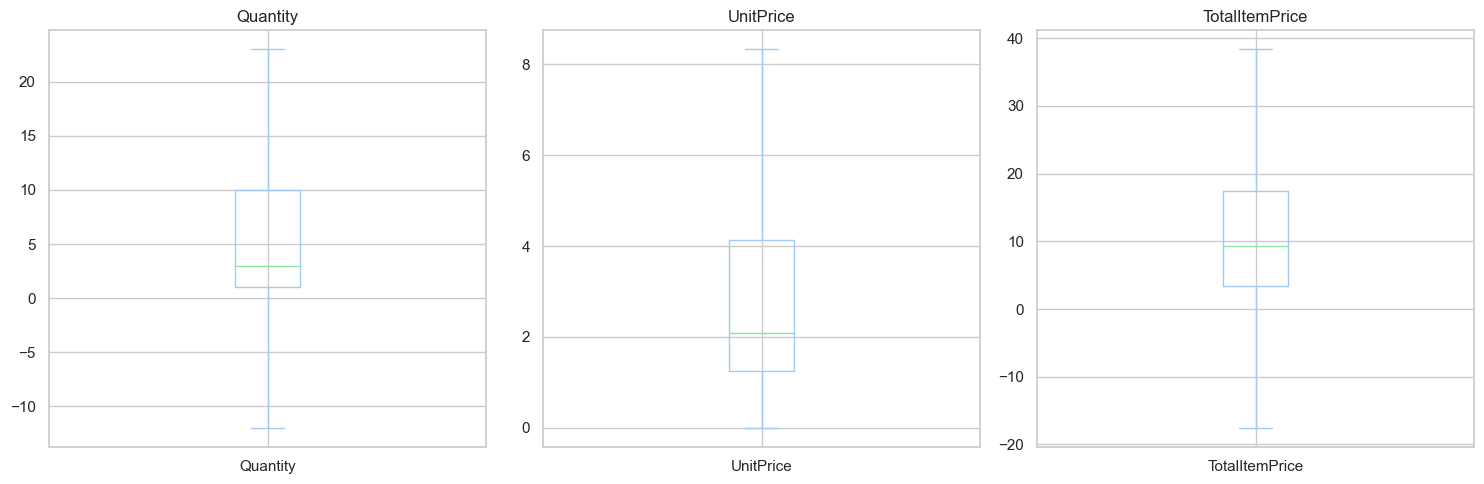

In [2100]:
create_boxplots(df, numerical_columns_=numerical_columns)


### Observations


In [2101]:
for observation in observations:
    display(Markdown(f"##### -> {observation}"))
    # print("\n")


##### -> ['Column InvoiceNo has 25610 unique values out of 514813 total rows. InvoiceNo repeats in the dataset. Take the example of InvoiceNo 579427, it has 20 rows in the dataset. Repeated InvoiceNo should not be deleted as they capture different items bought by the same customer.', 'InvoiceNo has two different types of values: Cancellation and Sale. Created a new feature called InvoiceType based on InvoiceNo. Dropped InvoiceNo column.']

##### -> ["StockCode and Description columns don't have matching number of unique values."]

##### -> ['There are no records where Quantity is set to 0.', 'There are 2401 records where UnitPrice is set to 0.', 'Among these zero unit price records, 2363 records have CustomerID set to NaN or customer is unknown.', 'There are 38 records where UnitPrice is set to 0 and Quantity is greater than 0. These 38 items are given for free.', 'These free items are given to 38 customers.', 'Number of free items given to unknown customers are: 1076']

##### -> ['Number of incorrect country names: 9022 out of 514813', "Incorrect country names: ['EIRE' 'Unspecified' 'Channel Islands' 'European Community' 'RSA']"]

##### -> `Quantity` has `negative` values.

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

### Are there any free items in the data? How many are there?

In [2102]:
# Done in previous sections


### 

### Find the number of transactions per country and visualize using an appropriate plot

In [2103]:
df.head(n=5)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,4.13,16479.0,United Kingdom,repeat,Sale,17.00,2011,11,29,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,10.0,0.42,17176.0,United Kingdom,repeat,Sale,10.08,2011,5,22,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6.0,0.42,16712.0,United Kingdom,repeat,Sale,2.52,2011,11,21,Monday
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12.0,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1.0,7.46,NaN,United Kingdom,unknown,Sale,7.46,2011,3,15,Tuesday


In [2104]:
df_insights = df.copy(deep=True)
print(df_insights.shape)
df_insights = df_insights.drop_duplicates(subset=["InvoiceNo"])
print(df_insights.shape)


(512228, 14)
(25161, 14)


/var/folders/x_/586jm8gs3s385026b8mq6gmc0000gn/T/ipykernel_83925/961779528.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


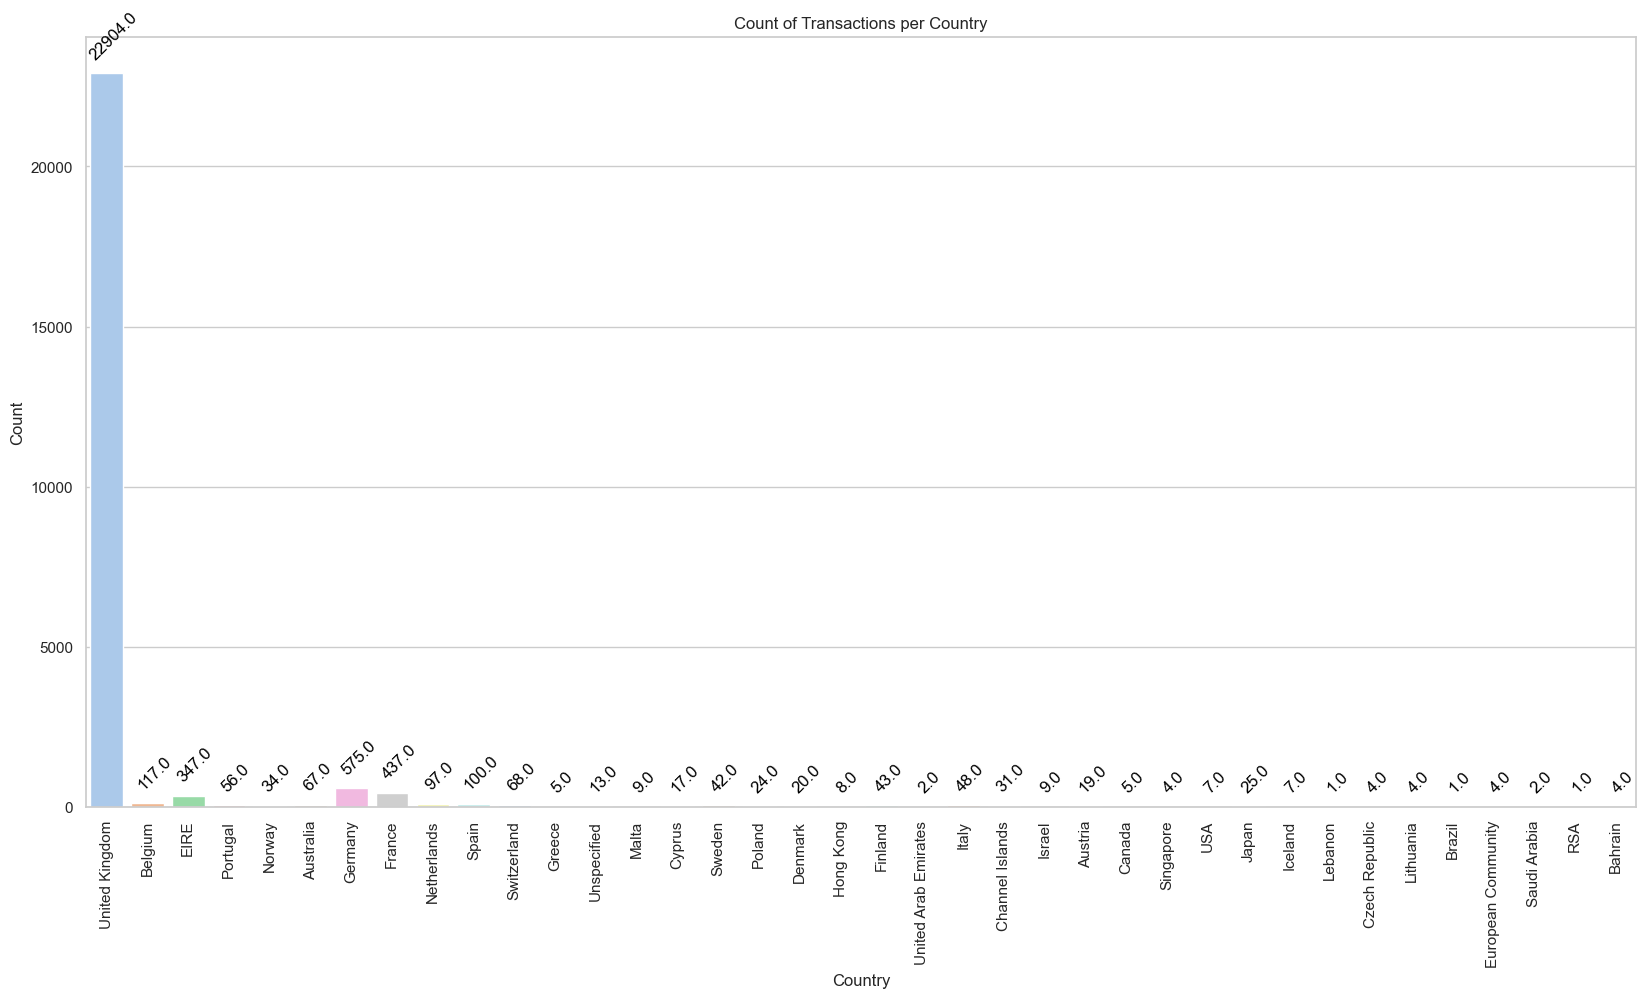

In [2105]:
# Find the number of transactions per country
# Should we consider each record as a transaction OR we have remove repeating InvoiceNo?
transactions_per_country = df["Country"].value_counts()

plt.figure(figsize=(20, 10))
ax = sns.countplot(data=df_insights, x="Country", palette="pastel")
plt.title("Count of Transactions per Country")
plt.xlabel("Country")
plt.ylabel("Count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="baseline",
        fontsize=12,
        color="black",
        xytext=(5, 10),
        textcoords="offset points",
        rotation=45,
    )

plt.show()


In [2106]:
# Let's take an example of Germany
df_insights[df_insights["Country"] == "Germany"].head(n=5)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
93,577615,21682,LARGE MEDINA STAMPED METAL BOWL,4.0,4.95,12658.0,Germany,repeat,Sale,19.80,2011,11,21,Monday
192,540458,84997A,GREEN 3 PIECE POLKADOT CUTLERY SET,6.0,3.75,12501.0,Germany,repeat,Sale,22.50,2011,1,7,Friday
235,569017,23515,EMBROIDERED RIBBON REEL DAISY,6.0,2.08,13813.0,Germany,repeat,Sale,12.48,2011,9,30,Friday
297,548745,22728,ALARM CLOCK BAKELIKE PINK,8.0,3.75,12471.0,Germany,repeat,Sale,30.00,2011,4,4,Monday
316,539446,84012,MAGIC SHEEP WOOL GROWING FROM PAPER,10.0,0.85,12705.0,Germany,repeat,Sale,20.40,2010,12,17,Friday


### What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

In [2107]:
df_repeat_customer = (
    df_insights.groupby("CustomerID")
    .agg(Invoice_Count=("InvoiceNo", "count"))
    .reset_index()
)
df_repeat_customer_count_more_than_1 = df_repeat_customer[
    df_repeat_customer["Invoice_Count"] > 1
]
count_df_repeat_customer_count_more_than_1 = len(df_repeat_customer_count_more_than_1)
df_repeat_customer_count_more_than_1.head(n=5)


,CustomerID,Invoice_Count
0,12346.0,2
1,12347.0,7
2,12348.0,4
5,12352.0,8
9,12356.0,3


In [2108]:
df_repeat_customer_count_equal_1 = df_repeat_customer[
    df_repeat_customer["Invoice_Count"] == 1
]
count_df_repeat_customer_count_equal_1 = len(df_repeat_customer_count_equal_1)
df_repeat_customer_count_equal_1.head(n=5)


,CustomerID,Invoice_Count
3,12349.0,1
4,12350.0,1
6,12353.0,1
7,12354.0,1
8,12355.0,1


In [2109]:
percentage_repeat_customers = (
    count_df_repeat_customer_count_more_than_1
    * 100
    / (
        count_df_repeat_customer_count_more_than_1
        + count_df_repeat_customer_count_equal_1
    )
)
print(f"Percentage of repeat customers: {percentage_repeat_customers:.2f}%")


Percentage of repeat customers: 69.37%


### Plot heatmap showing unit price per month and day of the week
**Hint:** Month name as index on Y-axis, Day of the week on X-axis

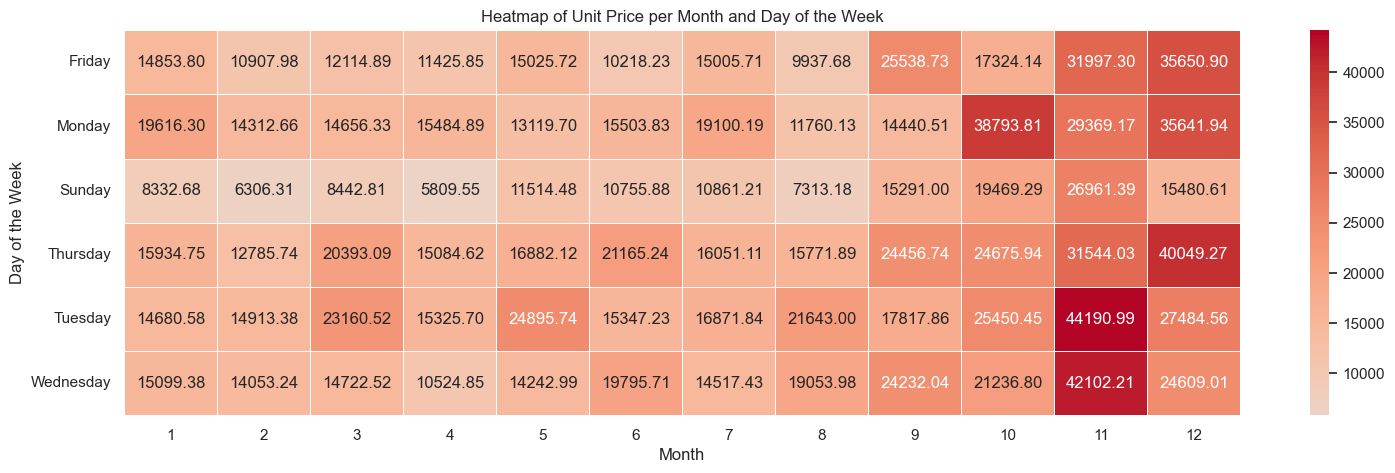

In [2110]:
# Create a pivot table with UnitPrice
pivot_table = df.pivot_table(
    values="UnitPrice", index="DayOfWeek", columns="Month", aggfunc="sum"
)

# Plot heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(
    pivot_table, annot=True, fmt=".2f", linewidth=0.5, center=0, cmap="coolwarm"
)
plt.title("Heatmap of Unit Price per Month and Day of the Week")
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.show()


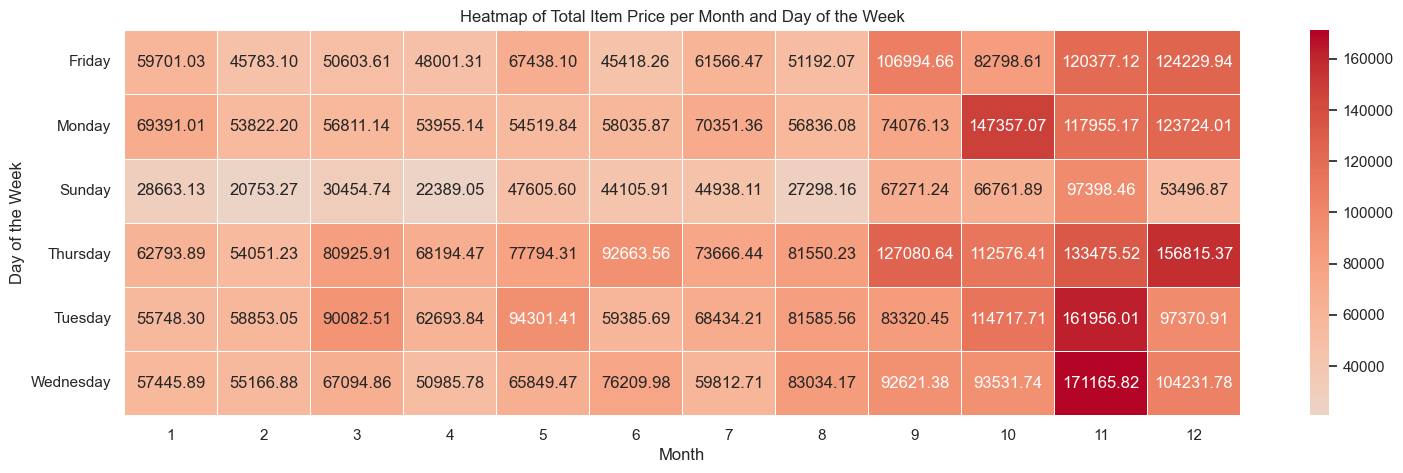

In [2111]:
# Create a pivot table with TotalItemPrice
pivot_table = df.pivot_table(
    values="TotalItemPrice", index="DayOfWeek", columns="Month", aggfunc="sum"
)

# Plot heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(
    pivot_table, annot=True, fmt=".2f", linewidth=0.5, center=0, cmap="coolwarm"
)
plt.title("Heatmap of Total Item Price per Month and Day of the Week")
plt.xlabel("Month")
plt.ylabel("Day of the Week")
plt.show()


### Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [2112]:
df[df["CustomerID"].isna()].head(n=5)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12.0,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1.0,7.46,NaN,United Kingdom,unknown,Sale,7.46,2011,3,15,Tuesday
6,564758,84951A,SET OF 4 PISTACHIO LOVEBIRD COASTER,1.0,2.46,NaN,United Kingdom,unknown,Sale,2.46,2011,8,30,Tuesday
15,579777,23222,CHRISTMAS TREE HANGING GOLD,1.0,1.63,NaN,United Kingdom,unknown,Sale,1.63,2011,11,30,Wednesday
24,578067,23344,JUMBO BAG 50'S CHRISTMAS,2.0,4.13,NaN,United Kingdom,unknown,Sale,8.26,2011,11,22,Tuesday


In [2113]:
# Find the top 10 customers who bought the most number of items
top_customers = df.groupby("CustomerID")["Quantity"].sum().nlargest(10)
print("Top 10 customers who bought the most number of items:")
print(top_customers)


Top 10 customers who bought the most number of items:
CustomerID
14911.0    43076.0
14646.0    18504.0
17841.0    18036.0
13089.0    16819.0
14298.0    16435.0
14096.0    14113.0
12748.0    14050.0
14156.0    11029.0
13081.0     9924.0
15311.0     9864.0
Name: Quantity, dtype: float64



Top 10 items bought by the most number of customers:
StockCode  CustomerID
79321      17841.0       61
21975      17841.0       52
22423      14911.0       52
21927      17841.0       51
22355      17841.0       48
22467      17841.0       47
22475      17841.0       41
21672      17841.0       40
21935      17841.0       38
47421      17841.0       38
Name: count, dtype: int64


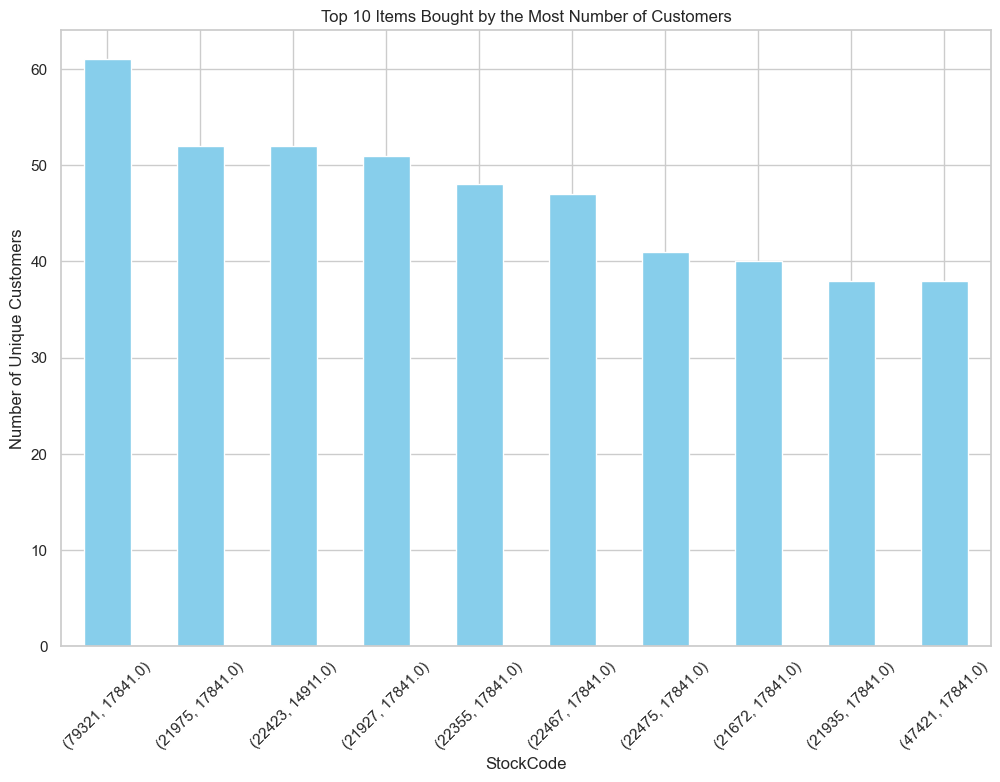

In [2114]:
# Find the top 10 items bought by the most number of customers
top_items = (
    df.groupby(["StockCode", "CustomerID"])["CustomerID"].value_counts().nlargest(10)
)
print("\nTop 10 items bought by the most number of customers:")
print(top_items)

# Plot the top 10 items bought by the most number of customers
plt.figure(figsize=(12, 8))
top_items.plot(kind="bar", color="skyblue")
plt.title("Top 10 Items Bought by the Most Number of Customers")
plt.xlabel("StockCode")
plt.ylabel("Number of Unique Customers")
plt.xticks(rotation=45)
plt.show()



Top 10 items bought by the most number of customers:
StockCode
22423     860
85123A    827
47566     685
84879     654
85099B    621
22720     618
21212     617
22086     593
22457     572
22138     568
Name: CustomerID, dtype: int64


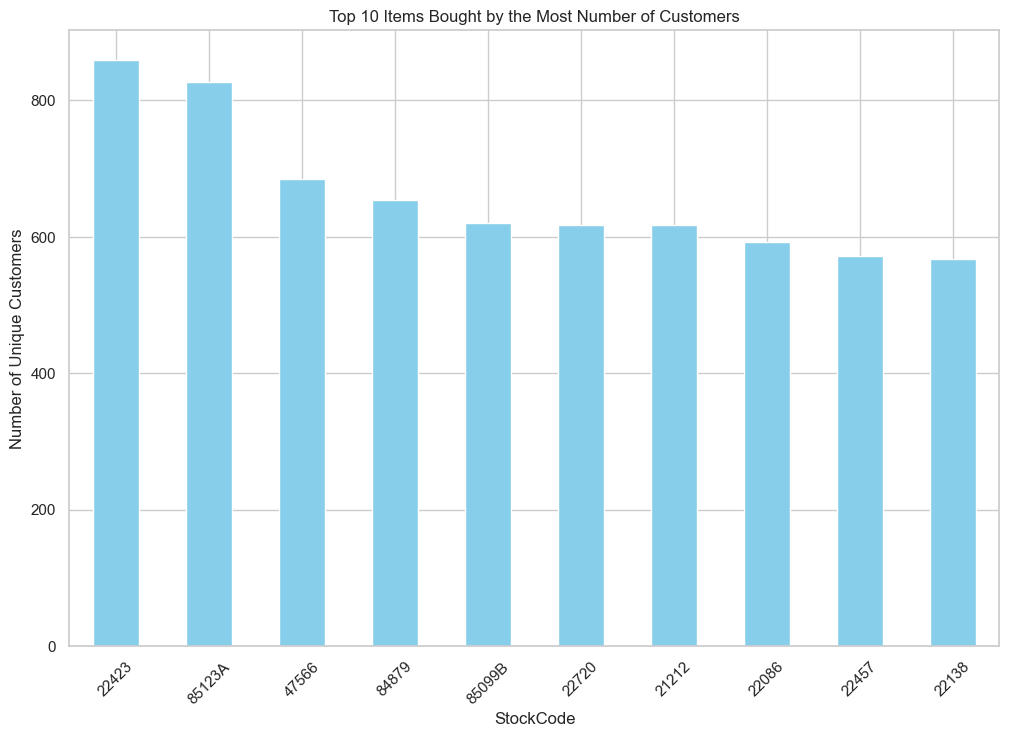

In [2115]:
# Find the top 10 items bought by the most number of customers
top_items = df.groupby("StockCode")["CustomerID"].nunique().nlargest(10)
print("\nTop 10 items bought by the most number of customers:")
print(top_items)

# Plot the top 10 items bought by the most number of customers
plt.figure(figsize=(12, 8))
top_items.plot(kind="bar", color="skyblue")
plt.title("Top 10 Items Bought by the Most Number of Customers")
plt.xlabel("StockCode")
plt.ylabel("Number of Unique Customers")
plt.xticks(rotation=45)
plt.show()


## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [2116]:
# First part already done

# Let me come back to this later
# grouped = df.groupby("CustomerID").sum()
# grouped
# df


In [2117]:
df.isnull().sum()


InvoiceNo               0
StockCode               0
Description          1379
Quantity                0
UnitPrice               0
CustomerID         127410
Country                 0
CustomerType            0
TransactionType         0
TotalItemPrice          0
Year                    0
Month                   0
Day                     0
DayOfWeek               0
dtype: int64

In [2118]:
len(df[df["UnitPrice"] < 1])


108864

### Scale the data

Apply `StandardScaler` on the features.

In [2119]:
df.head(n=5)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2.0,4.13,16479.0,United Kingdom,repeat,Sale,17.00,2011,11,29,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,10.0,0.42,17176.0,United Kingdom,repeat,Sale,10.08,2011,5,22,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6.0,0.42,16712.0,United Kingdom,repeat,Sale,2.52,2011,11,21,Monday
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-12.0,1.25,NaN,United Kingdom,unknown,Cancelled,-15.00,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,1.0,7.46,NaN,United Kingdom,unknown,Sale,7.46,2011,3,15,Tuesday


In [2120]:
# YOUR CODE HERE for scaling

df = scale_numerical_columns(df_=df, numerical_columns_=numerical_columns)
df.head(n=5)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,-0.682408,0.789607,16479.0,United Kingdom,repeat,Sale,0.750347,2011,11,29,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,1.052253,-1.168313,17176.0,United Kingdom,repeat,Sale,-0.073441,2011,5,22,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,0.184922,-1.168313,16712.0,United Kingdom,repeat,Sale,-0.973419,2011,11,21,Monday
3,C571196,23350,ROLL WRAP VINTAGE SPOT,-3.718064,-0.730288,NaN,United Kingdom,unknown,Cancelled,-3.059080,2011,10,14,Friday
4,546649,84509a,SET OF 4 ENGLISH ROSE PLACEMATS,-0.899240,2.546986,NaN,United Kingdom,unknown,Sale,-0.385338,2011,3,15,Tuesday


In [2121]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 512228 entries, 0 to 514812
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   InvoiceNo        512228 non-null  object 
 1   StockCode        512228 non-null  object 
 2   Description      510849 non-null  object 
 3   Quantity         512228 non-null  float64
 4   UnitPrice        512228 non-null  float64
 5   CustomerID       384818 non-null  float64
 6   Country          512228 non-null  object 
 7   CustomerType     512228 non-null  object 
 8   TransactionType  512228 non-null  object 
 9   TotalItemPrice   512228 non-null  float64
 10  Year             512228 non-null  int32  
 11  Month            512228 non-null  int32  
 12  Day              512228 non-null  int32  
 13  DayOfWeek        512228 non-null  object 
dtypes: float64(4), int32(3), object(7)
memory usage: 52.8+ MB


In [2122]:
df = df.drop(columns=["InvoiceNo", "Description", "CustomerID"], axis=1)
df.head(n=5)


,StockCode,Quantity,UnitPrice,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek
0,22636,-0.682408,0.789607,United Kingdom,repeat,Sale,0.750347,2011,11,29,Tuesday
1,21916,1.052253,-1.168313,United Kingdom,repeat,Sale,-0.073441,2011,5,22,Sunday
2,84692,0.184922,-1.168313,United Kingdom,repeat,Sale,-0.973419,2011,11,21,Monday
3,23350,-3.718064,-0.730288,United Kingdom,unknown,Cancelled,-3.059080,2011,10,14,Friday
4,84509a,-0.899240,2.546986,United Kingdom,unknown,Sale,-0.385338,2011,3,15,Tuesday


In [2123]:
label_encoder = LabelEncoder()
df["StockCode_Encoded"] = label_encoder.fit_transform(df["StockCode"])
df.drop("StockCode", axis=1, inplace=True)
df.head(n=5)


,Quantity,UnitPrice,Country,CustomerType,TransactionType,TotalItemPrice,Year,Month,Day,DayOfWeek,StockCode_Encoded
0,-0.682408,0.789607,United Kingdom,repeat,Sale,0.750347,2011,11,29,Tuesday,1549
1,1.052253,-1.168313,United Kingdom,repeat,Sale,-0.073441,2011,5,22,Sunday,932
2,0.184922,-1.168313,United Kingdom,repeat,Sale,-0.973419,2011,11,21,Monday,3185
3,-3.718064,-0.730288,United Kingdom,unknown,Cancelled,-3.059080,2011,10,14,Friday,2229
4,-0.899240,2.546986,United Kingdom,unknown,Sale,-0.385338,2011,3,15,Tuesday,3069


In [2124]:
print(df["DayOfWeek"].unique())
# Create a mapping dictionary
day_mapping = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7,
}

# Replace the DayOfWeek column with numbers
df["DayOfWeek"] = df["DayOfWeek"].map(day_mapping)
print(df["DayOfWeek"].unique())


['Tuesday' 'Sunday' 'Monday' 'Friday' 'Wednesday' 'Thursday']
[2 7 1 5 3 4]


In [2125]:
df["DayOfWeek_Sin"] = np.sin(2 * np.pi * (df["DayOfWeek"] / 7))
df["DayOfWeek_Cos"] = np.cos(2 * np.pi * (df["DayOfWeek"] / 7))
df["Month_Sin"] = np.sin(2 * np.pi * (df["Month"] / 7))
df["Month_Cos"] = np.cos(2 * np.pi * (df["Month"] / 7))
df["Day_Sin"] = np.sin(2 * np.pi * (df["Day"] / 7))
df["Day_Cos"] = np.cos(2 * np.pi * (df["Day"] / 7))
df = df.drop(columns=["DayOfWeek", "Month", "Day"], axis=1)
df.head(n=5)


,Quantity,UnitPrice,Country,CustomerType,TransactionType,TotalItemPrice,Year,StockCode_Encoded,DayOfWeek_Sin,DayOfWeek_Cos,Month_Sin,Month_Cos,Day_Sin,Day_Cos
0,-0.682408,0.789607,United Kingdom,repeat,Sale,0.750347,2011,1549,9.749279e-01,-0.222521,-0.433884,-0.900969,7.818315e-01,0.62349
1,1.052253,-1.168313,United Kingdom,repeat,Sale,-0.073441,2011,932,-2.449294e-16,1.000000,-0.974928,-0.222521,7.818315e-01,0.62349
2,0.184922,-1.168313,United Kingdom,repeat,Sale,-0.973419,2011,3185,7.818315e-01,0.623490,-0.433884,-0.900969,-7.347881e-16,1.00000
3,-3.718064,-0.730288,United Kingdom,unknown,Cancelled,-3.059080,2011,2229,-9.749279e-01,-0.222521,0.433884,-0.900969,-4.898587e-16,1.00000
4,-0.899240,2.546986,United Kingdom,unknown,Sale,-0.385338,2011,3069,9.749279e-01,-0.222521,0.433884,-0.900969,7.818315e-01,0.62349


In [2126]:
# ordinal_encoder = OrdinalEncoder(categories=[["Monday", "Tuesday", "Wednesday"]])
# df["Ordinal_Encoded"] = ordinal_encoder.fit_transform(df[["OrdinalFeature"]])


In [2127]:
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
nominal_encoded = one_hot_encoder.fit_transform(
    df[["Country", "CustomerType", "TransactionType"]]
)
nominal_encoded_df = pd.DataFrame(
    nominal_encoded,
    columns=one_hot_encoder.get_feature_names_out(
        ["Country", "CustomerType", "TransactionType"]
    ),
)
df = pd.concat([df, nominal_encoded_df], axis=1)
df = df.drop(columns=["Country", "CustomerType", "TransactionType"], axis=1)
df.head(n=5)


,Quantity,UnitPrice,TotalItemPrice,Year,StockCode_Encoded,DayOfWeek_Sin,DayOfWeek_Cos,Month_Sin,Month_Cos,Day_Sin,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,CustomerType_unique,CustomerType_unknown,TransactionType_Cancelled,TransactionType_Sale
0,-0.682408,0.789607,0.750347,2011.0,1549.0,9.749279e-01,-0.222521,-0.433884,-0.900969,7.818315e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.052253,-1.168313,-0.073441,2011.0,932.0,-2.449294e-16,1.000000,-0.974928,-0.222521,7.818315e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.184922,-1.168313,-0.973419,2011.0,3185.0,7.818315e-01,0.623490,-0.433884,-0.900969,-7.347881e-16,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-3.718064,-0.730288,-3.059080,2011.0,2229.0,-9.749279e-01,-0.222521,0.433884,-0.900969,-4.898587e-16,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,-0.899240,2.546986,-0.385338,2011.0,3069.0,9.749279e-01,-0.222521,0.433884,-0.900969,7.818315e-01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


#### Question
Why am I getting NaN after encoding?


In [2128]:
df[df.isna()].head(n=5)


,Quantity,UnitPrice,TotalItemPrice,Year,StockCode_Encoded,DayOfWeek_Sin,DayOfWeek_Cos,Month_Sin,Month_Cos,Day_Sin,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,CustomerType_unique,CustomerType_unknown,TransactionType_Cancelled,TransactionType_Sale
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2129]:
print(df.shape)
df = df.dropna()
df[df.isna().any(axis=1)].head(n=5)
# print(df.shape)


(514801, 52)


,Quantity,UnitPrice,TotalItemPrice,Year,StockCode_Encoded,DayOfWeek_Sin,DayOfWeek_Cos,Month_Sin,Month_Cos,Day_Sin,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,CustomerType_unique,CustomerType_unknown,TransactionType_Cancelled,TransactionType_Sale


## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [2130]:
# YOUR CODE HERE to apply KMeans
kmeans = KMeans(n_clusters=5, n_init=5, max_iter=100, random_state=42)
y_predict = kmeans.fit_predict(df)


In [2131]:
y_predict


array([4, 3, 2, ..., 4, 4, 3], shape=(509655,), dtype=int32)

In [2132]:
print(f"Centroids are: \n{kmeans.cluster_centers_}")


Centroids are: 
[[ 9.83468020e-02  3.98858730e-03  1.13876222e-01  2.01098179e+03
   2.12776758e+03  1.52120049e-01 -1.72944186e-01 -1.26475482e-02
  -3.12659204e-01  6.67267883e-02  2.50712675e-03  7.82925115e-04
   4.44843815e-05  3.69220367e-03  8.89687631e-05  3.46978176e-04
   1.48577834e-03  1.17438767e-03  7.11750105e-05  6.49471970e-04
   1.50802053e-02  1.24556268e-04  1.28115019e-03  1.50979991e-02
   1.66638493e-02  2.84700042e-04  5.51606331e-04  3.29184423e-04
   6.31678218e-04  1.39680958e-03  7.20646981e-04  9.78656394e-05
   8.00718868e-05  1.95731279e-04  4.41285065e-03  2.04628155e-03
   5.96090713e-04  2.64237226e-03  1.51246897e-04  4.44843815e-05
   4.18153186e-04  4.67086006e-03  7.47337610e-04  3.60323490e-03
   5.33812578e-04  1.51246897e-04  9.15693200e-01  8.71893878e-04
   1.95731279e-04  2.47591171e-01  1.63702524e-02  9.83629748e-01]
 [ 2.45558071e-02 -1.33568048e-01 -1.15399967e-01  2.01090641e+03
   3.57446577e+02  1.68151517e-01 -1.88384980e-01 -1.460391

In [2133]:
print(f"Number of clusters (centroids) found are: {len(kmeans.cluster_centers_)}")
print(f"Each centroid has {len(kmeans.cluster_centers_[0])} coordinates")


Number of clusters (centroids) found are: 5
Each centroid has 52 coordinates


In [2134]:
kmeans.labels_


array([4, 3, 2, ..., 4, 4, 3], shape=(509655,), dtype=int32)

In [2135]:
np.unique(kmeans.labels_, return_counts=True)


(array([0, 1, 2, 3, 4], dtype=int32),
 array([112399,  81847,  82328, 100924, 132157]))

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

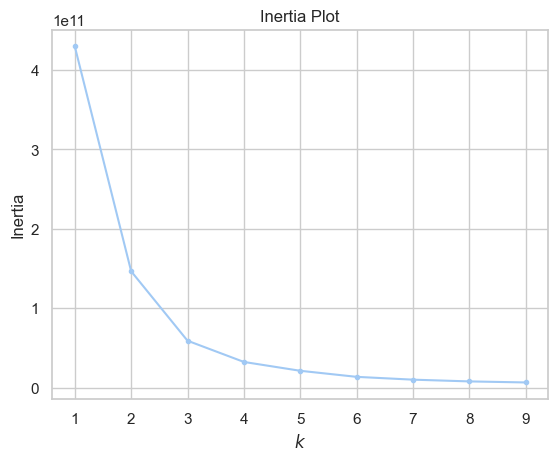

In [2136]:
# YOUR CODE HERE
# Plot inertia by varying number of clusters
clusters = np.arange(1, 10)
inertia = []
for c in clusters:
    kmeans = KMeans(n_clusters=c, random_state=42)
    kmeans.fit(df, y_predict)
    inertia.append(kmeans.inertia_)
plt.plot(clusters, inertia, marker=".")
# plt.arrow(5, 100, -5, -110)
# plt.text(5, 410, "Elbow", fontdict={"size": 12})
plt.title("Inertia Plot")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.show()


In [2137]:
# Plot Silhouette score plot

# This calculation is computationally expensive and is running for a long time.

clusters = np.arange(2, 4)
sil_score = []
for c in clusters:
    kmeans2 = KMeans(n_clusters=c, random_state=42)
    # kmeans2.fit(df, y_predict)
    # sil_score.append(silhouette_score(df, kmeans2.labels_))
# plt.plot(clusters, sil_score, marker=".")
# plt.title("Silhouette score plot")
# plt.xlabel("$k$")
# plt.ylabel("Silhouette score")
# plt.show()


### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


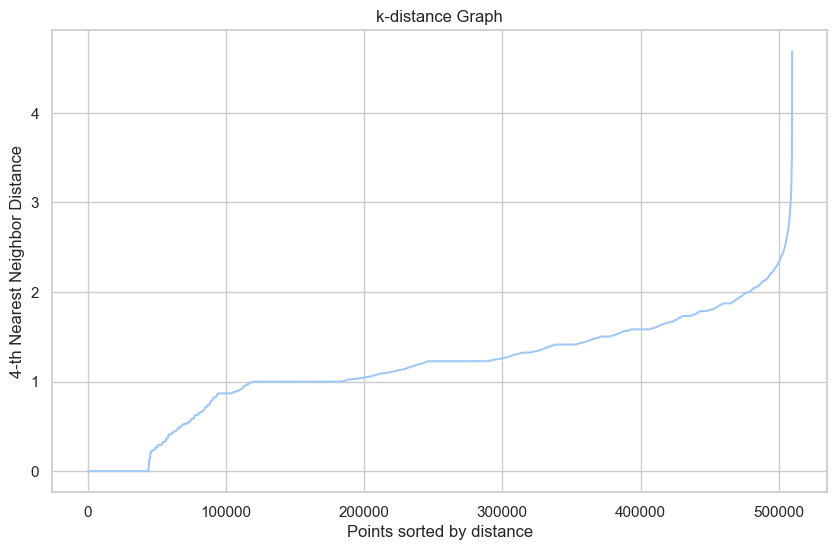

In [2138]:
k = 4  # Typically, k is set to min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(df)
distances, indices = neighbors.kneighbors(df)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, k - 1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("k-distance Graph")
plt.show()


In [2139]:
# YOUR CODE HERE
dbscan = DBSCAN(eps=0.1, min_samples=10, n_jobs=-1)
dbscan.fit(df)
print("Unique clusters in data: ", np.unique(dbscan.labels_))


Unique clusters in data:  [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216]


In [ ]:
# Add visualization for DBSCAN labels calculated above


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [1958]:
df.columns.tolist()


['Quantity',
 'UnitPrice',
 'TotalItemPrice',
 'Year',
 'StockCode_Encoded',
 'DayOfWeek_Sin',
 'DayOfWeek_Cos',
 'Month_Sin',
 'Month_Cos',
 'Day_Sin',
 'Day_Cos',
 'Country_Austria',
 'Country_Bahrain',
 'Country_Belgium',
 'Country_Brazil',
 'Country_Canada',
 'Country_Channel Islands',
 'Country_Cyprus',
 'Country_Czech Republic',
 'Country_Denmark',
 'Country_EIRE',
 'Country_European Community',
 'Country_Finland',
 'Country_France',
 'Country_Germany',
 'Country_Greece',
 'Country_Hong Kong',
 'Country_Iceland',
 'Country_Israel',
 'Country_Italy',
 'Country_Japan',
 'Country_Lebanon',
 'Country_Lithuania',
 'Country_Malta',
 'Country_Netherlands',
 'Country_Norway',
 'Country_Poland',
 'Country_Portugal',
 'Country_RSA',
 'Country_Saudi Arabia',
 'Country_Singapore',
 'Country_Spain',
 'Country_Sweden',
 'Country_Switzerland',
 'Country_USA',
 'Country_United Arab Emirates',
 'Country_United Kingdom',
 'Country_Unspecified',
 'CustomerType_unique',
 'CustomerType_unknown',
 'Tr

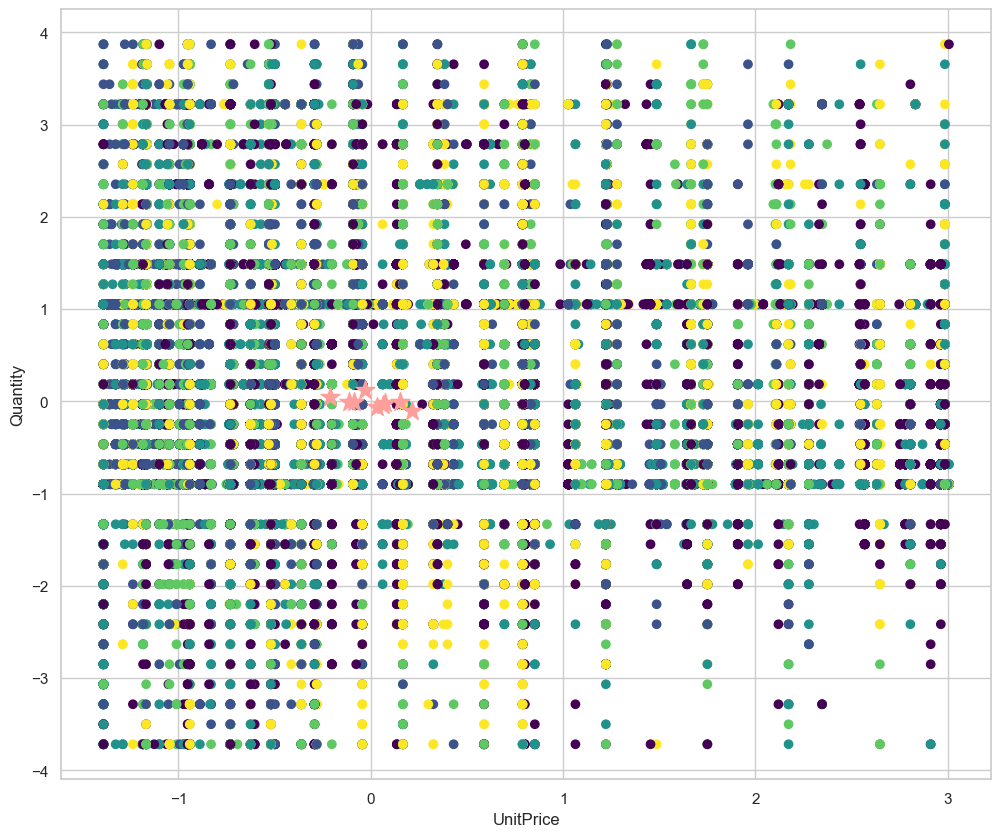

In [1959]:
# YOUR CODE HERE
plt.figure(figsize=(12, 10))
plt.scatter(df.iloc[:, 1], df.iloc[:, 0], c=y_predict, cmap="viridis")
plt.xlabel(df.columns[1])
plt.ylabel(df.columns[0])
# Plot centroids after iteration
plt.scatter(
    x=kmeans.cluster_centers_[:, 1],
    y=kmeans.cluster_centers_[:, 0],
    c="r",
    marker="*",
    s=200,
)
plt.show()


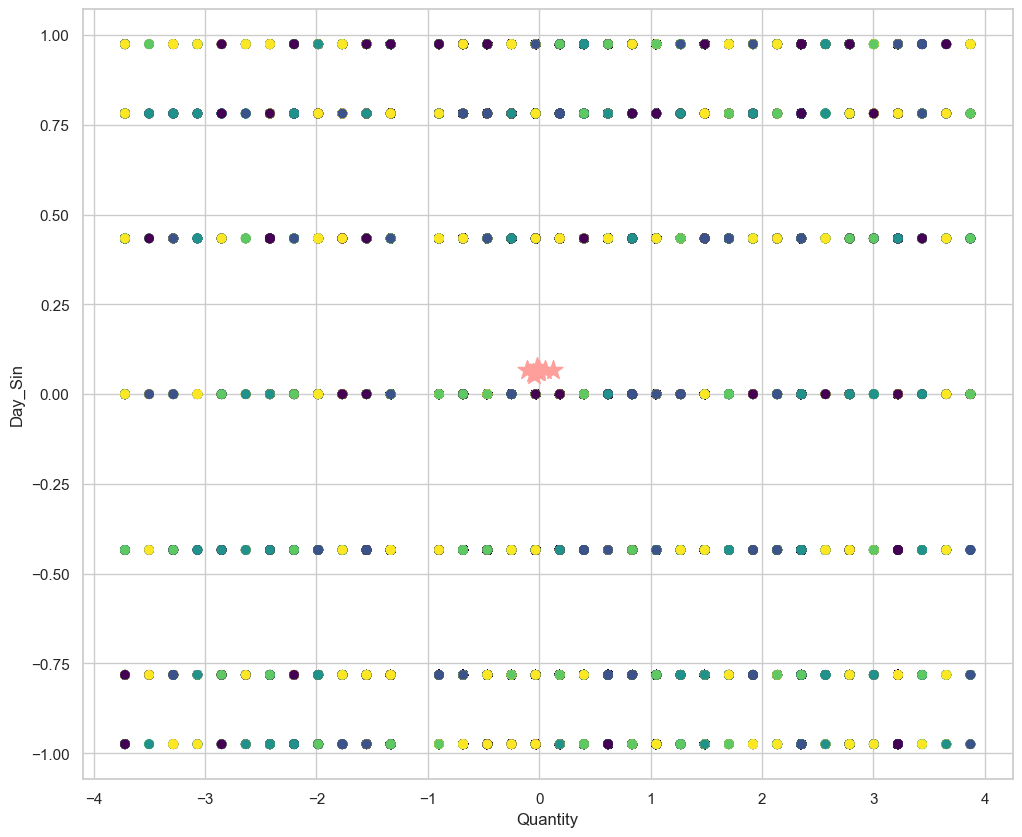

In [1960]:
plt.figure(figsize=(12, 10))
plt.scatter(df.iloc[:, 0], df.iloc[:, 9], c=y_predict, cmap="viridis")
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[9])
# Plot centroids after iteration
plt.scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 9],
    c="r",
    marker="*",
    s=200,
)
plt.show()


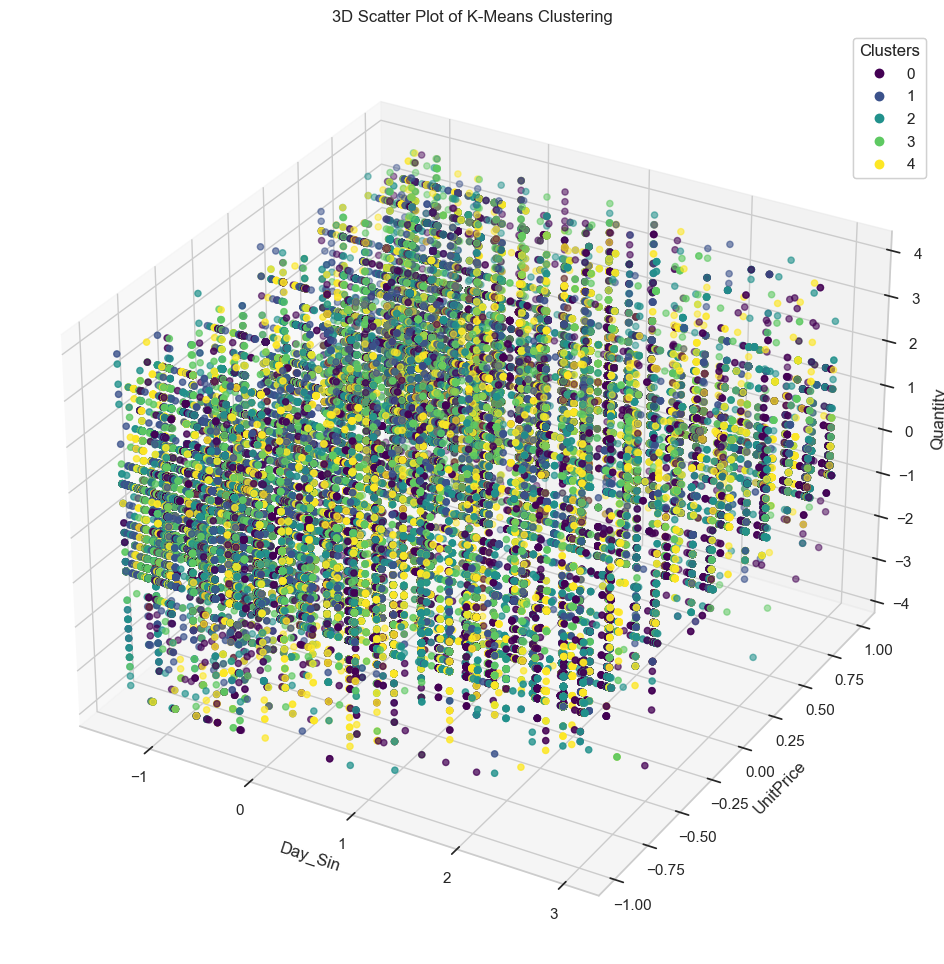

In [1961]:
# Plot the 3D scatter plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    df["UnitPrice"], df["Day_Sin"], df["Quantity"], c=y_predict, cmap="viridis"
)

# Add labels
ax.set_xlabel("Day_Sin")
ax.set_ylabel("UnitPrice")
ax.set_zlabel("Quantity")
ax.set_title("3D Scatter Plot of K-Means Clustering")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


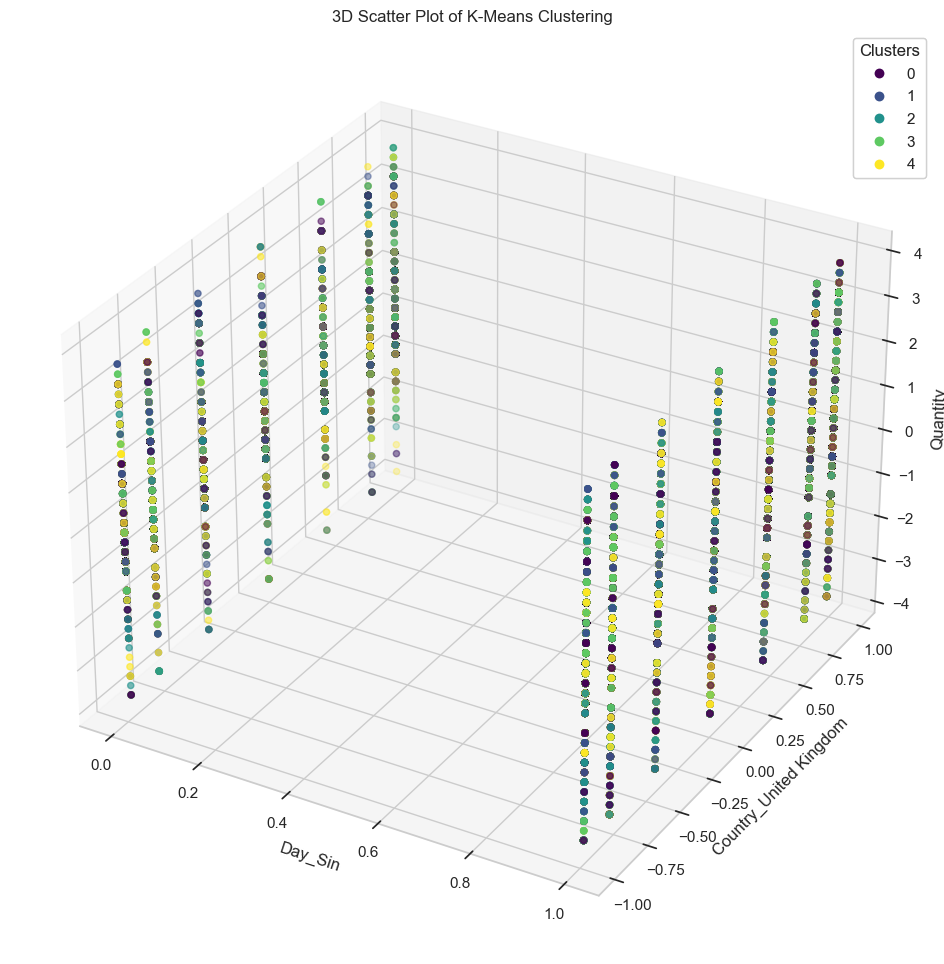

In [1962]:
# Plot the 3D scatter plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    df["Country_United Kingdom"],
    df["Day_Sin"],
    df["Quantity"],
    c=y_predict,
    cmap="viridis",
)

# Add labels
ax.set_xlabel("Day_Sin")
ax.set_ylabel("Country_United Kingdom")
ax.set_zlabel("Quantity")
ax.set_title("3D Scatter Plot of K-Means Clustering")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


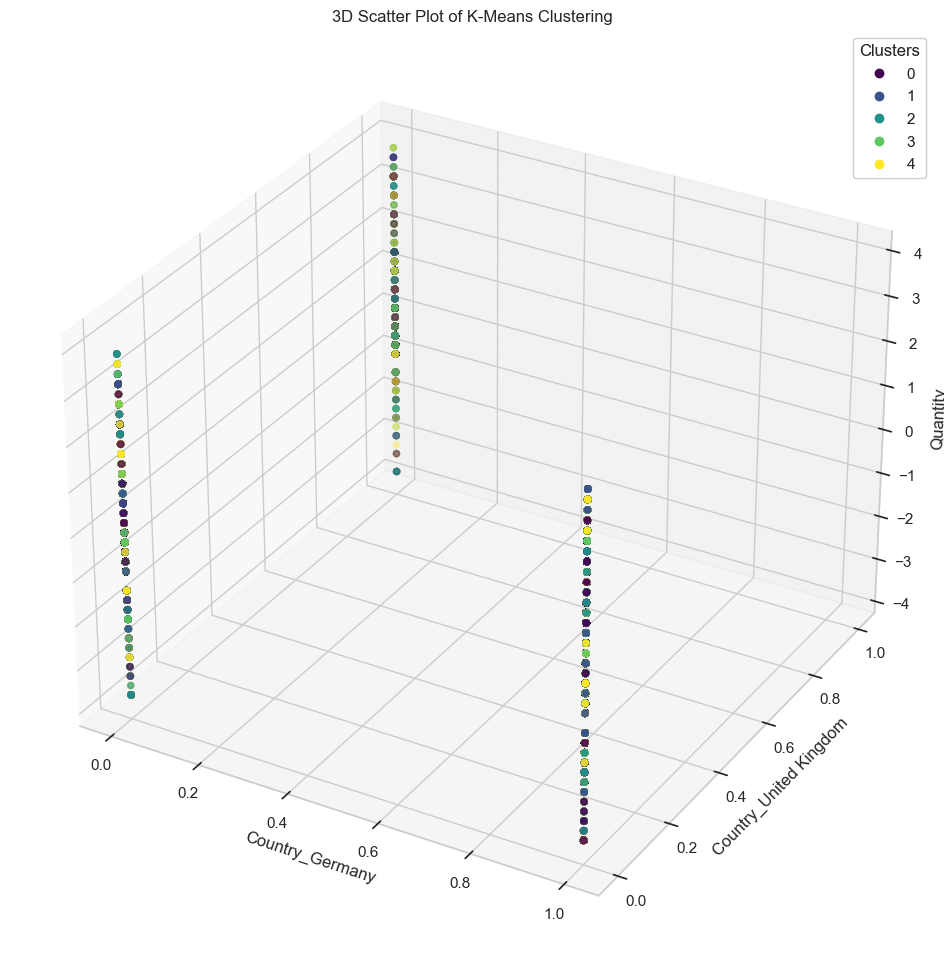

In [1963]:
# Plot the 3D scatter plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot
scatter = ax.scatter(
    df["Country_United Kingdom"],
    df["Country_Germany"],
    df["Quantity"],
    c=y_predict,
    cmap="viridis",
)

# Add labels
ax.set_xlabel("Country_Germany")
ax.set_ylabel("Country_United Kingdom")
ax.set_zlabel("Quantity")
ax.set_title("3D Scatter Plot of K-Means Clustering")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()


### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [1964]:
# YOUR CODE HERE
x_train, x_val, y_train, y_val = train_test_split(
    df, y_predict, stratify=y_predict, test_size=0.20, random_state=42
)
x_train.shape, y_train.shape, x_val.shape, y_val.shape


((407724, 52), (407724,), (101931, 52), (101931,))

In [1965]:
# # Create CatBoost model
# CatBoost_clf = CatBoostClassifier(
#     # cat_features=categorical_columns_trimmed,
#     iterations=200,
#     learning_rate=0.2,
#     random_state=42,
#     # max_depth=8,
#     # class_weights=class_weights_dict,
#     # auto_class_weights="Balanced",
#     # loss_function="CrossEntropy"
# )


In [1966]:
# CatBoost_clf.fit(
#     x_train,
#     y_train,
#     eval_set=(x_val, y_val),
#     verbose=False,
# )


In [1971]:
model = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4,
    # gamma=params["gamma"],
    # min_child_weight=params["min_child_weight"],
    # subsample=params["subsample"],
    # colsample_bytree=params["colsample_bytree"],
    # scale_pos_weight=scale_pos_weight,
    random_state=42,
)
model.fit(x_train, y_train)
y_pred = model.predict(x_val)


In [1969]:
f1 = f1_score(y_pred, y_val, average="weighted")
print(f"F1 Score: {f1:.2f}")


F1 Score: 1.00


In [1970]:
classification_report_ = classification_report(y_pred, y_val)
print(classification_report_)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22479
           1       1.00      1.00      1.00     16319
           2       1.00      1.00      1.00     16458
           3       1.00      1.00      1.00     20237
           4       1.00      1.00      1.00     26438

    accuracy                           1.00    101931
   macro avg       1.00      1.00      1.00    101931
weighted avg       1.00      1.00      1.00    101931



### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)


In [ ]:
# YOUR CODE HERE


### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?